In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_212277/2699245673.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
COLLECT_TS = "2024-08-03T05:51:31.266846823+00:00"
TARGET_PID = "357450"
PATH = "figures/cassandra"
FIGSIZE=(3.2, 3)
os.makedirs(PATH, exist_ok=True)

# Target

In [3]:
target = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/percentile_50.csv")
MIN_TIMESTAMP, MAX_TIMESTAMP = target["epoch_s"].min(), target["epoch_s"].max()

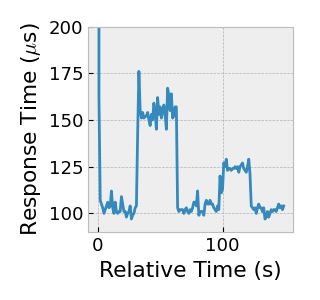

In [4]:
plt.close("all")

plt.figure(figsize=FIGSIZE)
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["delay_us"])
plt.xlabel("Relative Time (s)")
plt.ylabel("Response Time ($\mu$s)")
plt.ylim([90,200])
plt.tight_layout()
plt.savefig(f"{PATH}/target_response_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

**Observations**

1. There are 2 moments where the response time sees a sharp increase, (30-64) and (95-123)
2. The first performance degradation interval is a result of concurrently starting the ycsb-read workload at the same time as the ycsb-update intensive workload.
3. The second performance degradation interval is a result of concurrently starting background processes which perform disk intensive workloads.

# Scenario 1

## Scheduling Statistics

We start by analysing the interesting scheduling statistics of all threads that are part of our process for the first scenario, which involved starting the read intensive ycsb workload concurrently.

In [78]:
XLIM, YLIM = [0, 90], [0, 1.1]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

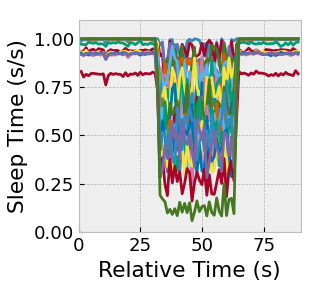

In [80]:
threads = metrics.columns.str.replace(r"thread/\d+/(\d+?)/.*", r"\1", regex=True).unique().drop("epoch_s")
res = {}

for thread in threads:
    res[f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate"] = 1 - (metrics[f"thread/{TARGET_PID}/{thread}/sched/runtime_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/rq_time_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/block_time_rate"])

sleep_times = pd.DataFrame(res)
sleep_times["epoch_s"] = metrics["epoch_s"]
sleep_times = pd.merge(sleep_times, target, on="epoch_s", how="outer")
sleep_times = sleep_times.loc[(sleep_times["epoch_s"] > START_TIMESTAMP) & (sleep_times["epoch_s"] < END_TIMESTAMP), :]
corr = sleep_times.corr()["delay_us"]
corr = corr.sort_values(ascending=False)
significant_corr = corr[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Sleep Time (s/s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(sleep_times["epoch_s"] - MIN_TIMESTAMP, sleep_times[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_1_sleep_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

tmp_sleep_threads = threads

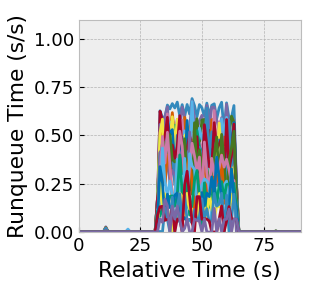

In [82]:
plt.close("all")

XLIM, YLIM = [0, 90], [0, 1.1]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]


# Sched Runtime

# col_filter = metrics.columns[metrics.columns.str.contains("runtime_rate")].append(pd.Index(["epoch_s"]))
# sched = metrics.loc[:, col_filter]
# sched = pd.merge(sched, target, on="epoch_s", how="outer")
# sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
# corr = sched.corr()["delay_us"]
# corr = corr.sort_values(ascending=False)
# significant_corr = corr[(corr > 0.5) | (corr < -0.5)]

# plt.figure(figsize=FIGSIZE)
# plt.title("Runtime")
# plt.xlabel("relative time (s)")
# threads = pd.Index([])
# for col in significant_corr.index: 
#     if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
#         continue
#     threads = threads.append(pd.Index([col]))
#     plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
# plt.xlim(XLIM)
# plt.ylim(YLIM)
# plt.tight_layout()
# plt.show()

# runtime_threads = threads

# Sched Runqueue

col_filter = metrics.columns[metrics.columns.str.contains("rq_time_rate")].append(pd.Index(["epoch_s"]))
rq = metrics.loc[:, col_filter]
rq = pd.merge(rq, target, on="epoch_s", how="outer")
rq = rq.loc[(rq["epoch_s"] > START_TIMESTAMP) & (rq["epoch_s"] < END_TIMESTAMP), :]
corr = rq.corr()["delay_us"]
corr = corr.sort_values(ascending=False)
significant_corr = corr[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.xlabel("Relative Time (s)")
plt.ylabel("Runqueue Time (s/s)")
rq_threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
        continue
    rq_threads = rq_threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_1_runqueue_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [40]:
sleep_threads = set(sleep_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
sleep_threads = set(tmp_sleep_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
rq_threads = set(rq_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
runtime_threads = set(runtime_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

In [41]:
print(rq_threads - runtime_threads, f"# of rq threads {len(rq_threads)}")
print(sleep_threads - runtime_threads, f"# of sleep threads {len(sleep_threads)}")
print(sleep_threads - rq_threads, f"# of sleep threads {len(sleep_threads)}")

{'357584'} # of rq threads 23
{'357584'} # of sleep threads 24
{'367365'} # of sleep threads 24


**Observations**

1. There is a sudden dip in the time the threads spend in a sleeping state.
2. There is some change in activity in runtime, however not enough to justify such a large dip in sleep time.
3. We then observe that most of the sleep time can be accounted for by the increase in the time each thread spends waiting in the runqueue.

# Scenario 2

The second scenario involved starting the background disk-intensive threads at the same time as our ycsb-update process was executing. Similarly, we start this analysis by attempting to understand the scheduling statistics.

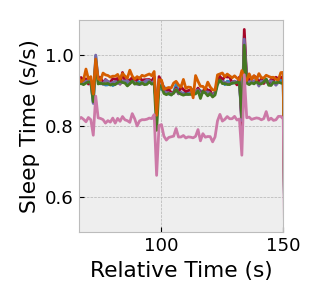

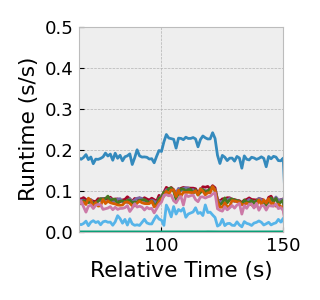

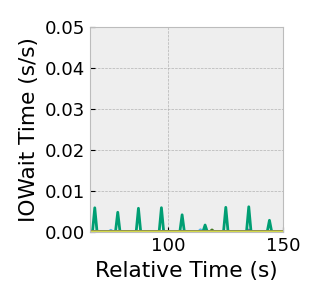

In [5]:
XLIM, YLIM = [66, 150], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

# Sched Sleep

col_filter = metrics.columns[metrics.columns.str.contains("sleep_time_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target, on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()["delay_us"]
corr = corr.sort_values(ascending=False)
significant_corr = corr [(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Sleep Time (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim([0.5, 1.1])
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_2_sleep_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

sleep_threads = threads

# Sched Runtime

col_filter = metrics.columns[metrics.columns.str.contains("runtime_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target, on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()["delay_us"]
corr = corr.sort_values(ascending=False)
significant_corr = corr[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runtime (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim([0, 0.5])
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_2_runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

runtime_threads = threads

# Sched IOWait

col_filter = metrics.columns[metrics.columns.str.contains("iowait_time_rate")].append(pd.Index(["epoch_s"]))
sched = metrics.loc[:, col_filter]
sched = pd.merge(sched, target, on="epoch_s", how="outer")
sched = sched.loc[(sched["epoch_s"] > START_TIMESTAMP) & (sched["epoch_s"] < END_TIMESTAMP), :]
corr = sched.corr()["delay_us"]
corr = corr.sort_values(ascending=False)
significant_corr = corr#[(corr > 0.5) | (corr < -0.5)]

plt.figure(figsize=FIGSIZE)
plt.ylabel("IOWait Time (s/s)")
plt.xlabel("Relative Time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_us" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim(XLIM)
plt.ylim([0, 0.05])
plt.tight_layout()
plt.savefig(f"{PATH}/scenario_2_iowait_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

iowait_threads = threads

sleep_threads = set(sleep_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())
runtime_threads = set(runtime_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

In [23]:
print(sleep_threads - runtime_threads, f"# of sleep threads {len(sleep_threads)}")

set() # of sleep threads 6


**Observations**

1. There is a dip in the time the threads spend in a sleeping state.
2. There isn't a significant change on the time the threads spend in a blocked state (which would also include the in_iowait state).
3. There is an increase in runtime that seems to match the dip in sleep time. The difference between the sleep and runtime sets also confirms this observation.

## IO Wait

The following analysis will be an attempt to understand the iowait behaviour of our application.

global/357450/357586/global_iowait/264241152/sector_cnt
global/357450/357586/global_iowait/264241153/sector_cnt


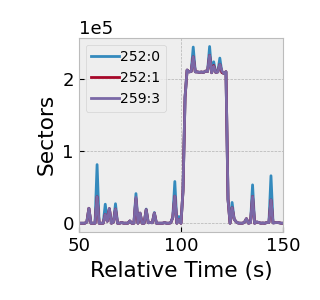

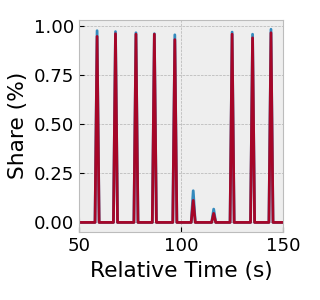

In [74]:
import re

XLIM = [50, 150]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/iowait")
metric_files = pd.Series(metric_files)
metrics = v0_2_0.metric_files_to_df(metric_files)

# Calculate device total

devices = metrics.columns.str.replace(r".*/global_iowait/(\d+)/.*", r"\1", regex=True).unique()
devices = devices[~devices.str.contains("epoch_s")]
device_total = pd.DataFrame()
for device in devices:
    col_filter = col_filter = metrics.columns[metrics.columns.str.contains(f"/{device}/")]
    metrics_device = metrics.loc[:, col_filter]
    device_total[device] = metrics_device.sum(axis=1)

# Plot per thread 

plt.figure(figsize=FIGSIZE)
plt.ylabel("Sectors")
plt.xlabel("Relative Time (s)")
target_threads = metrics.columns[metrics.columns.str.contains(TARGET_PID)]
for col in target_threads:
    if col == "epoch_s":
        continue
    print(col)
    label = re.sub(r"global/(\d+)/(\d+)/global_iowait/(\d+)/.*", r"\1/\2/\3", col)
    # plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=label)
    
for device in devices:
    MAJOR, MINOR = int(device) >> 20, int(device) & ((1 << 20) - 1)
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, device_total[device], label=f"{MAJOR}:{MINOR}")
plt.legend(prop={"size": 10}, handletextpad=0.1, columnspacing=0.5)
plt.xlim(XLIM)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig(f"{PATH}/device_total.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.ylabel("Share (%)")
plt.xlabel("Relative Time (s)")
pid_tids = metric_files.str.replace(rf".*/iowait/({TARGET_PID})/(\d+)/.*", r"\1/\2", regex=True).unique()
# pid_tids = ["250468/250783", "250468/250787", "250468/259654", "718/718"]
for pid_tid in pid_tids:
    for device in devices:
        col = f"global/{pid_tid}/global_iowait/{device}/sector_cnt"
        if not metrics.columns.str.contains(col).any():
            continue
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, (metrics[col]/device_total[device]).fillna(0), label=f"{pid_tid}/{device}")
# plt.legend()
plt.xlim(XLIM)
plt.tight_layout()
plt.savefig(f"{PATH}/device_share.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

**Observations**

1. We see that there is a sudden increase in the amount of requests performed to our devices
2. The rate at which the cassadndra threads perform disk request seems periodic, which also indicates that the persistence guarantees are not performed on a per-request basis, and the modifications are flushed only after a pre-defined interval of time.
3. The share of pending sector requests performed by a cassandra thread dips at the same time the contending disk processes are performing their disk-intensive tasks.

357450-0x7b4394b766f8
357450-0x7b4394b766fc


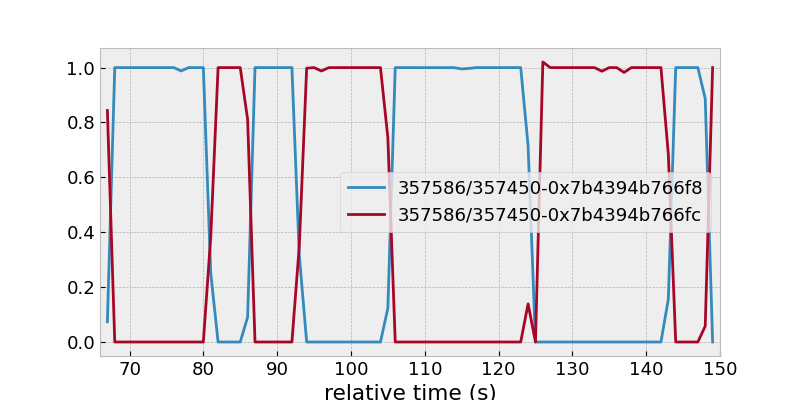

In [75]:
import re

START_TIMESTAMP = MIN_TIMESTAMP + 66
END_TIMESTAMP = MIN_TIMESTAMP + 150

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

plt.figure(figsize=(8, 4))
plt.xlabel("relative time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
futex_threads = set()
futex_address = set()
for thread in ["357586"]:
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"]))
    metrics = metrics.loc[(metrics["epoch_s"] > START_TIMESTAMP) & (metrics["epoch_s"] < END_TIMESTAMP), futex_wait_filter]
    metrics = pd.merge(metrics, target, on="epoch_s", how="outer")
    metrics = metrics.loc[:, :]
    
    corr = metrics.corr()["delay_us"]
    corr = corr.sort_values(ascending=False)
    corr = corr#[corr > 0.5].dropna()
    
    for col in corr.index:
        if "epoch_s" in col or "delay_us" in col: 
            continue
        
        if metrics[col].mean() < 0.2:
            continue
        futex = re.sub(r".*/wait/(.*?)/.*", r"\1", col)
        futex_threads.add(thread)
        futex_address.add(futex)
        print(futex)
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}/{futex}")
plt.xlim(66, 150)
plt.legend()
plt.show()

'358181'

'358181'

'358183'

'358185'

'358088'

'358088'

'358182'

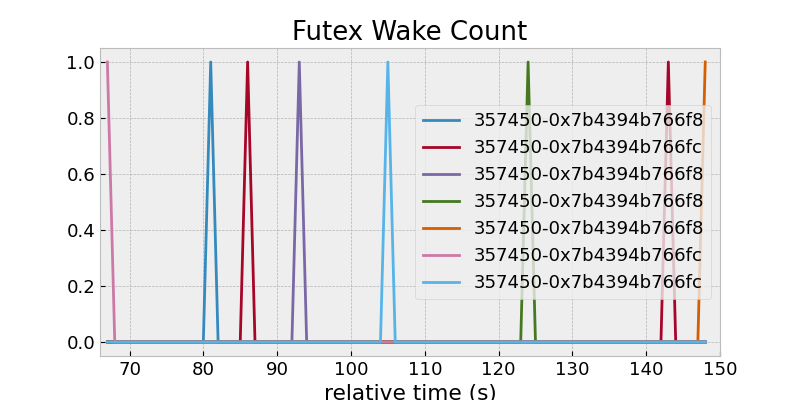

In [76]:
START_TIMESTAMP = MIN_TIMESTAMP + 66
END_TIMESTAMP = MIN_TIMESTAMP + 150

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close('all')
plt.figure(figsize=(8, 4))
plt.title(f"Futex Wake Count")
plt.xlabel("relative time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
wake_threads = set()
for thread in threads:
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    if not files.str.contains("|".join(futex_address)).any():
        continue

    for futex in futex_address:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        metrics = metrics.loc[(metrics["epoch_s"] > START_TIMESTAMP) & (metrics["epoch_s"] < END_TIMESTAMP), :]
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            if metrics[col].max() < 1:
                continue
            wake_threads.add(f"{thread}/{futex}")
            display(thread)
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{futex}")
plt.xlim([66, 150])
plt.legend()
plt.show()

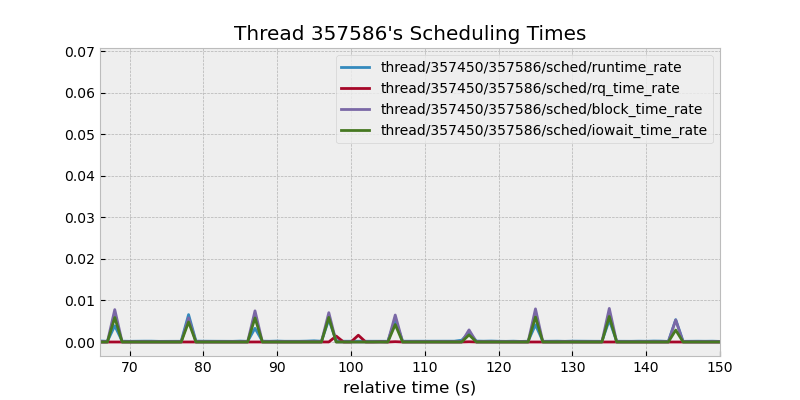

In [49]:
XLIM, YLIM = [0, MAX_TIMESTAMP-MIN_TIMESTAMP], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))

for thread in [357586]:
    plt.figure(figsize=(8, 4))
    plt.title(f"Thread {thread}'s Scheduling Times")
    plt.xlabel("relative time (s)")
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    rate_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"])).drop(f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate")
    metrics = metrics.loc[:, rate_filter]
    for col in metrics.columns:
        if col == "epoch_s": 
            continue
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=col)
    plt.legend()
    plt.xlim(66, 150)
    plt.show()

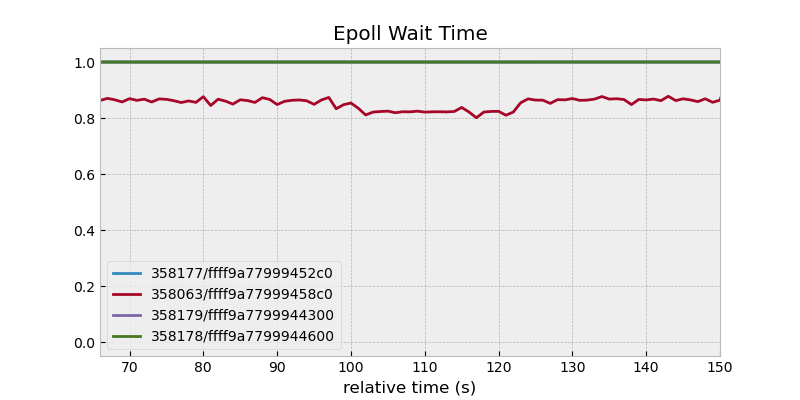

In [65]:
XLIM, YLIM = [66, 150], [0, 1.5]
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'epoll_' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

# long = metrics.melt(id_vars=["epoch_s"], value_vars=col_filter)
# res = long.groupby(["epoch_s"])["value"].sum()

plt.close("all")
plt.figure(figsize=(8, 4))
plt.title("Epoll Wait Time")
plt.xlabel("relative time (s)")
for col in metrics.columns: 
    if col == "epoch_s":
        continue
    thread, epoll = re.search(r"thread/\d+/(\d+)/.*epoll_(.*?)/", col).groups()
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}/{epoll}")
plt.xlim(XLIM)
plt.legend()
plt.show()

Who is thread 358063 waking? 

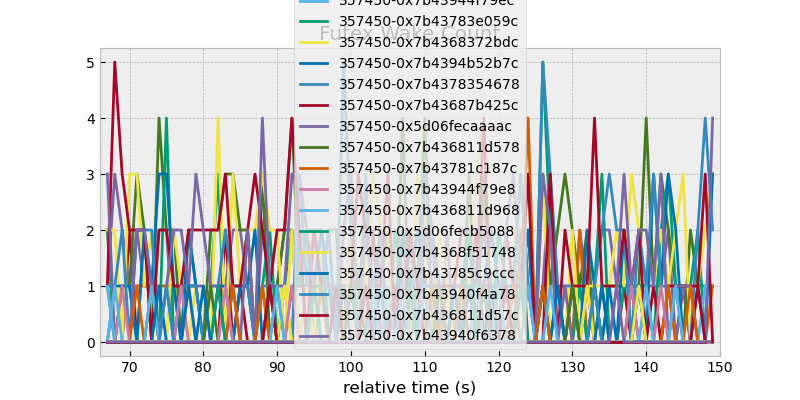

In [82]:
START_TIMESTAMP = MIN_TIMESTAMP + 66
END_TIMESTAMP = MIN_TIMESTAMP + 150

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close('all')
plt.figure(figsize=(8, 4))
plt.title(f"Futex Wake Count")
plt.xlabel("relative time (s)")

wake_futex = set()
for thread in ["358063"]:
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    futexes = futexes = files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique()
    for futex in futexes:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        metrics = metrics.loc[(metrics["epoch_s"] > START_TIMESTAMP) & (metrics["epoch_s"] < END_TIMESTAMP), :]
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            wake_futex.add(futex)
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{futex}")
plt.xlim([66, 150])
plt.legend()
plt.show()

In [90]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}/358063")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))
wait_futex = set(metric_files.str.replace(r".*/([\w-]+).csv$", r"\1", regex=True).unique())

In [92]:
workload_futex = wake_futex - wait_futex

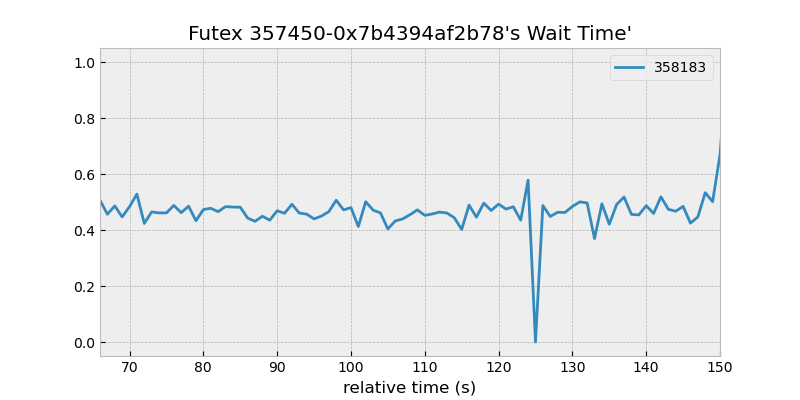

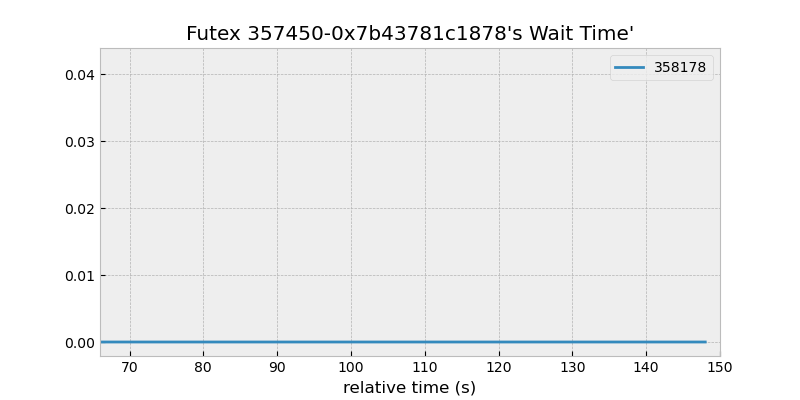

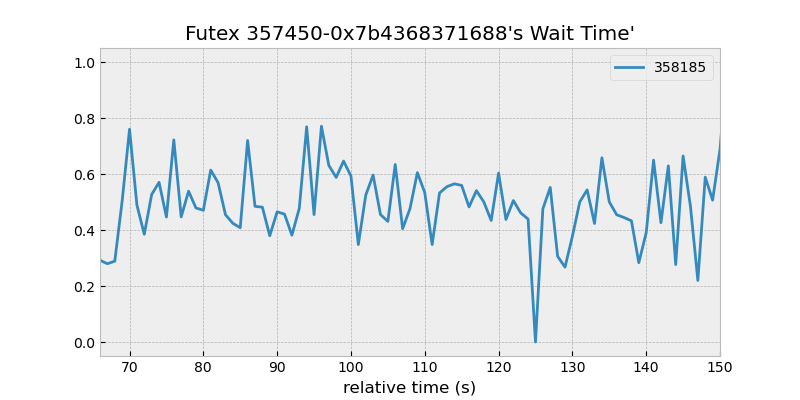

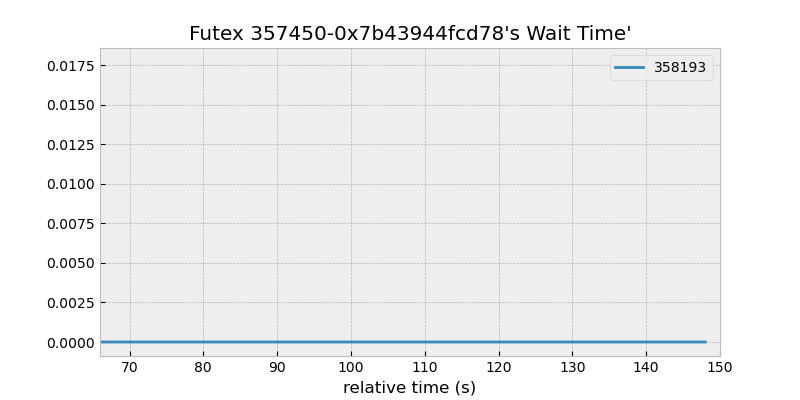

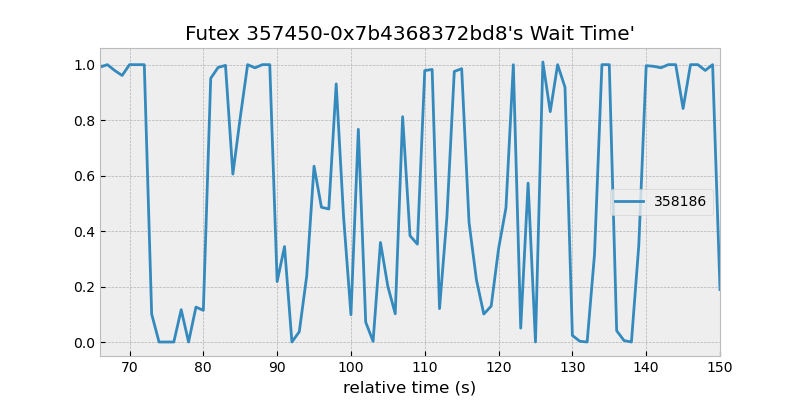

In [111]:
START_TIMESTAMP = MIN_TIMESTAMP + 66
END_TIMESTAMP = MIN_TIMESTAMP + 150

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

plt.close("all")

for futex in list(workload_futex)[15:20]:
    plt.figure(figsize=(8,4))
    plt.xlabel("relative time (s)")
    plt.title(f"Futex {futex}'s Wait Time'")
    files = metric_files[metric_files.str.contains(f"{futex}")]
    threads = files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
    for thread in threads:
        files = files[files.str.contains(f"{TARGET_PID}/{thread}")]
        metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        col_filter = metrics.columns[metrics.columns.str.contains("_rate")]
        for col in col_filter:
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
    plt.xlim(66, 150)
    plt.legend()
    plt.show()
        
# for thread in threads:
#     files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
#     metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
#     futex_wait_filter = metrics.columns[metrics.columns.str.contains("_rate")].append(pd.Index(["epoch_s"]))
#     metrics = metrics.loc[(metrics["epoch_s"] > START_TIMESTAMP) & (metrics["epoch_s"] < END_TIMESTAMP), futex_wait_filter]
#     metrics = pd.merge(metrics, target, on="epoch_s", how="outer")
#     metrics = metrics.loc[:, :]
    
#     corr = metrics.corr()["delay_us"]
#     corr = corr.sort_values(ascending=False)
#     corr = corr#[corr > 0.5].dropna()
    
#     for col in corr.index:
#         if "epoch_s" in col or "delay_us" in col: 
#             continue
#         futex = re.sub(r".*/wait/(.*?)/.*", r"\1", col)
#         plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}/{futex}")
